Forcasting in Engineering und Management

In [19]:
# ----------------------------------------
# Forecasting in Engineering & Management
# Main Notebook: FoEM_Projekt.ipynb
# Cleaned for S&P 500 only with TRAIN/TEST support
# ----------------------------------------

# Core packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Statistical tools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import BDay
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from prophet import Prophet

# ML/DL Tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Utilities
import os
import warnings
warnings.filterwarnings("ignore")
import logging
from datetime import timedelta

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [20]:
# Configurable year range and forecast length
HISTORY_YEARS = 5     # Change to 1, 2, 10, etc.
FORECAST_DAYS = 30    # Change to 60, 90 for different outlooks
TRAIN_SPLIT = 0.8     # 80% train, 20% test

In [21]:
# ----------------------------------------
# Step 2: Download & Clean S&P 500 Data
# ----------------------------------------

# Define ticker and dynamic date range
TICKER = "^GSPC"
end_date = dt.datetime.today()
start_date = end_date - timedelta(days=HISTORY_YEARS * 365)

# Fetch data
logging.info(f"📥 Downloading S&P 500 data from {start_date.date()} to {end_date.date()}...")
sp500 = yf.download(TICKER, start=start_date, end=end_date, progress=False, auto_adjust=False)

# Print raw structure (diagnostic)
print("\n📋 Raw Columns from yfinance:", sp500.columns.tolist())

# Flatten MultiIndex (remove ticker suffix like '^GSPC')
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = [col[0] for col in sp500.columns]

# Keep only relevant columns
expected_cols = ['Close', 'Open', 'High', 'Low', 'Volume']
available_cols = [col for col in expected_cols if col in sp500.columns]
sp500 = sp500[available_cols].copy()

# Set proper datetime index and clean
sp500.index = pd.to_datetime(sp500.index)
sp500 = sp500.asfreq('B')   # Business day frequency
sp500 = sp500.ffill()

# Output info
print(f"\n✅ Dataset Shape: {sp500.shape}")
print(f"🗓️  Time Range : {sp500.index.min().date()} → {sp500.index.max().date()}")
print("🔎 Columns     :", ', '.join(map(str, sp500.columns)))
print("\n🧼 Missing Values:")
print(sp500.isna().sum())

# Hint
print("\nℹ️ You can change HISTORY_YEARS to adjust dataset size.")

2025-05-18 01:58:10,947 - INFO - 📥 Downloading S&P 500 data from 2020-05-19 to 2025-05-18...



📋 Raw Columns from yfinance: [('Adj Close', '^GSPC'), ('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC')]

✅ Dataset Shape: (1304, 5)
🗓️  Time Range : 2020-05-19 → 2025-05-16
🔎 Columns     : Close, Open, High, Low, Volume

🧼 Missing Values:
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64

ℹ️ You can change HISTORY_YEARS to adjust dataset size.


In [22]:
sp500.head()

,Close,Open,High,Low,Volume
Date,,,,,
2020-05-19,2922.939941,2948.590088,2964.209961,2922.350098,4.984330e+09
2020-05-20,2971.610107,2953.629883,2980.290039,2953.629883,5.005380e+09
2020-05-21,2948.510010,2969.949951,2978.500000,2938.570068,4.976620e+09
2020-05-22,2955.449951,2948.050049,2956.760010,2933.590088,3.970860e+09
2020-05-25,2955.449951,2948.050049,2956.760010,2933.590088,3.970860e+09


In [23]:
sp500.describe()

,Close,Open,High,Low,Volume
count,1304.000000,1304.000000,1304.000000,1304.000000,1.304000e+03
mean,4470.647902,4469.465976,4495.472801,4442.051815,4.335703e+09
std,766.239173,766.208975,767.216333,764.716958,9.834298e+08
min,2922.939941,2948.050049,2956.760010,2922.350098,1.639500e+09
25%,3940.277588,3939.077454,3969.957581,3911.647461,3.759472e+09
50%,4357.794922,4356.389893,4380.229980,4327.650146,4.143485e+09
75%,4998.587646,4987.827515,5021.780029,4955.377563,4.688515e+09
max,6144.149902,6134.500000,6147.430176,6111.149902,9.976520e+09


In [24]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1304 entries, 2020-05-19 to 2025-05-16
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1304 non-null   float64
 1   Open    1304 non-null   float64
 2   High    1304 non-null   float64
 3   Low     1304 non-null   float64
 4   Volume  1304 non-null   float64
dtypes: float64(5)
memory usage: 61.1 KB


🧪 Train/Test Split: 1043 train days + 261 test days = 1304 total
🟩 Train Range: 2020-05-19 → 2024-05-16
🟥 Test Range : 2024-05-17 → 2025-05-16


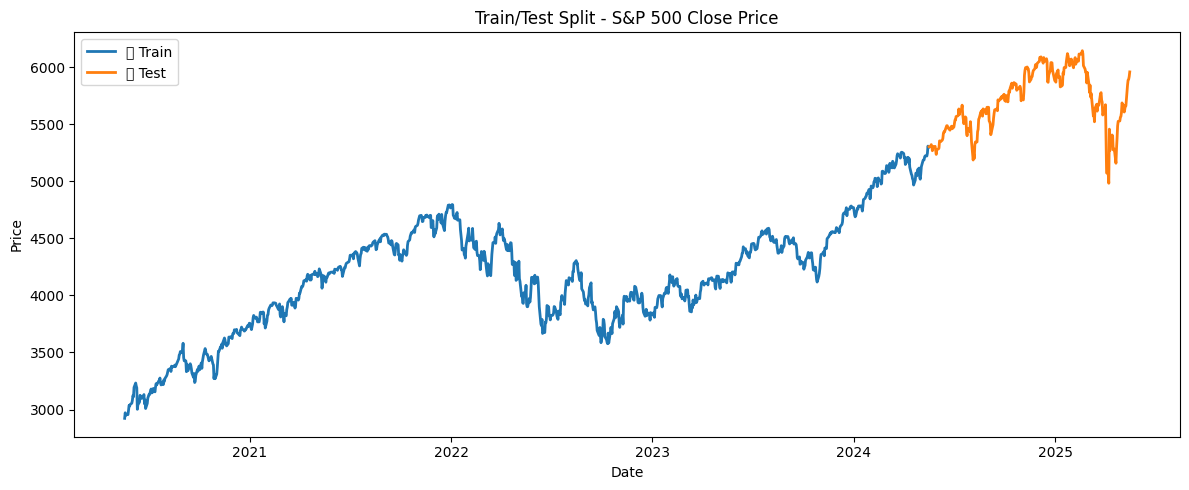

In [25]:
# ----------------------------------------
# Step 3: Create Time Series and Split
# ----------------------------------------

# Use only the 'Close' column for modeling
ts = sp500['Close'].copy()
ts.name = 'S&P 500 Close'
ts.index = pd.to_datetime(ts.index)

# Determine split index
split_idx = int(len(ts) * TRAIN_SPLIT)

# Create train/test splits
ts_train = ts.iloc[:split_idx]
ts_test = ts.iloc[split_idx:]

# Output overview
print(f"🧪 Train/Test Split: {len(ts_train)} train days + {len(ts_test)} test days = {len(ts)} total")
print(f"🟩 Train Range: {ts_train.index.min().date()} → {ts_train.index.max().date()}")
print(f"🟥 Test Range : {ts_test.index.min().date()} → {ts_test.index.max().date()}")

# Optional: Plot to visually inspect split
plt.figure(figsize=(12, 5))
plt.plot(ts_train, label="🟩 Train", linewidth=2)
plt.plot(ts_test, label="🟥 Test", linewidth=2)
plt.title("Train/Test Split - S&P 500 Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

In this step, we apply classical decomposition to the S&P 500 closing price time series.  
We break down the series into 3 components:
- **Trend**: Long-term movement over time
- **Seasonality**: Repeating short-term cycles (e.g., yearly financial trends)
- **Residual**: Remaining noise after removing trend and seasonality

To ensure decomposition works, we:
- Reindex the data to **business day frequency** (`'B'`)
- Apply **forward-fill** to handle non-trading days (which introduce NaNs)

The decomposition assumes **additive structure** and a period of **252 trading days per year**.

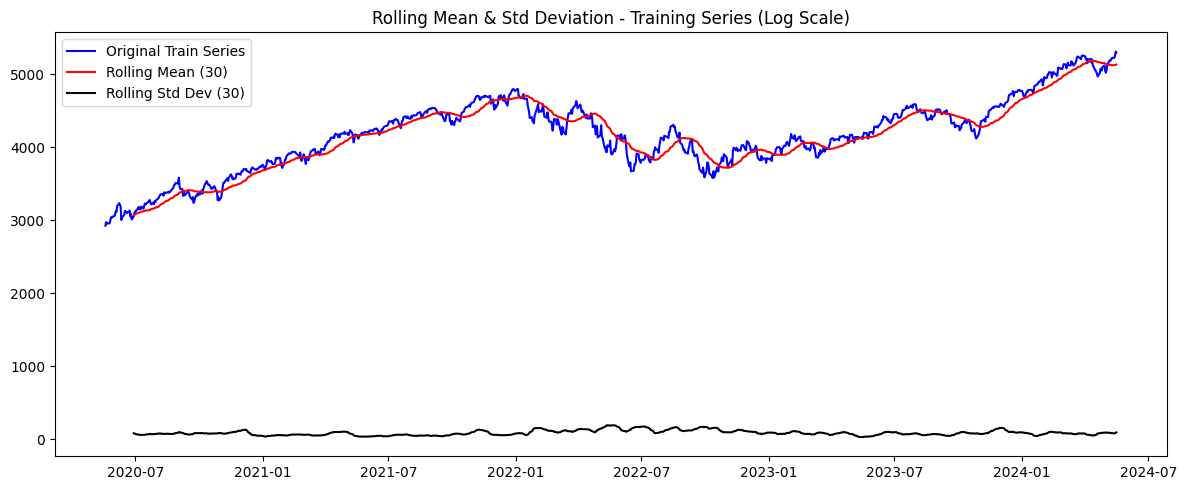

📊 Augmented Dickey-Fuller Test Results (Training Series):
ADF Statistic : -1.2813
p-value       : 0.6377
Critical Values:
   1% : -3.4367
   5% : -2.8643
   10% : -2.5683
❌ Likely NON-STATIONARY (Fail to reject H0)


In [30]:
# ----------------------------------------
# Step 5: Check Stationarity (Rolling Stats + ADF Test)
# ----------------------------------------

# Rolling statistics
rolmean = ts_train.rolling(window=30).mean()
rolstd = ts_train.rolling(window=30).std()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts_train, label='Original Train Series', color='blue')
plt.plot(rolmean, label='Rolling Mean (30)', color='red')
plt.plot(rolstd, label='Rolling Std Dev (30)', color='black')
plt.title("Rolling Mean & Std Deviation - Training Series (Log Scale)")
plt.legend()
plt.tight_layout()
plt.show()

# ADF test
adf_result = adfuller(ts_train.dropna())

# Print results
print("📊 Augmented Dickey-Fuller Test Results (Training Series):")
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key} : {value:.4f}")

# Interpretation
if adf_result[1] <= 0.05:
    print("✅ Likely STATIONARY (Reject H0)")
else:
    print("❌ Likely NON-STATIONARY (Fail to reject H0)")

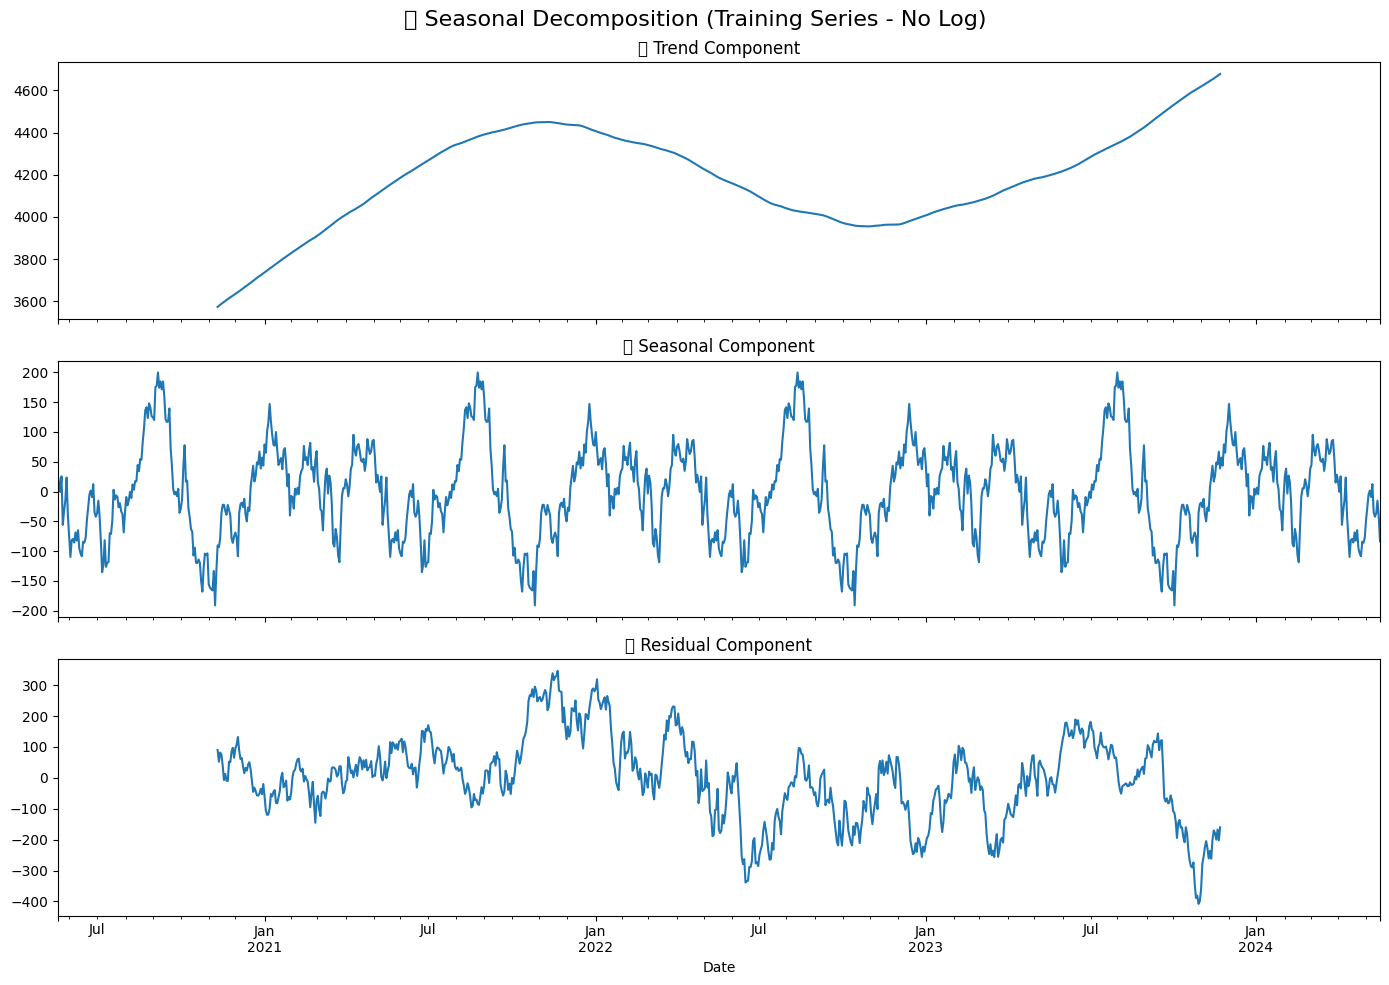

ℹ️ Decomposition helps isolate trend, recurring seasonal effects, and irregular noise.
   → You should see smoother long-term patterns in Trend.
   → Repetitive fluctuations in Seasonal.
   → Irregularities (spikes/outliers) in Residual.


In [47]:
# ----------------------------------------
# Step 6: Decompose Training Series (No Log)
# ----------------------------------------

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the training series (Additive Model, 252 = ~1 year of trading days)
decomposition = seasonal_decompose(ts_train, model='additive', period=252)

# Plot the decomposition
fig, (trend_ax, seasonal_ax, resid_ax) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

decomposition.trend.plot(ax=trend_ax, title="🔻 Trend Component")
decomposition.seasonal.plot(ax=seasonal_ax, title="🔁 Seasonal Component")
decomposition.resid.plot(ax=resid_ax, title="🔹 Residual Component")

plt.suptitle("📉 Seasonal Decomposition (Training Series - No Log)", fontsize=16)
plt.tight_layout()
plt.show()

# Interpretation Hint
print("ℹ️ Decomposition helps isolate trend, recurring seasonal effects, and irregular noise.")
print("   → You should see smoother long-term patterns in Trend.")
print("   → Repetitive fluctuations in Seasonal.")
print("   → Irregularities (spikes/outliers) in Residual.")

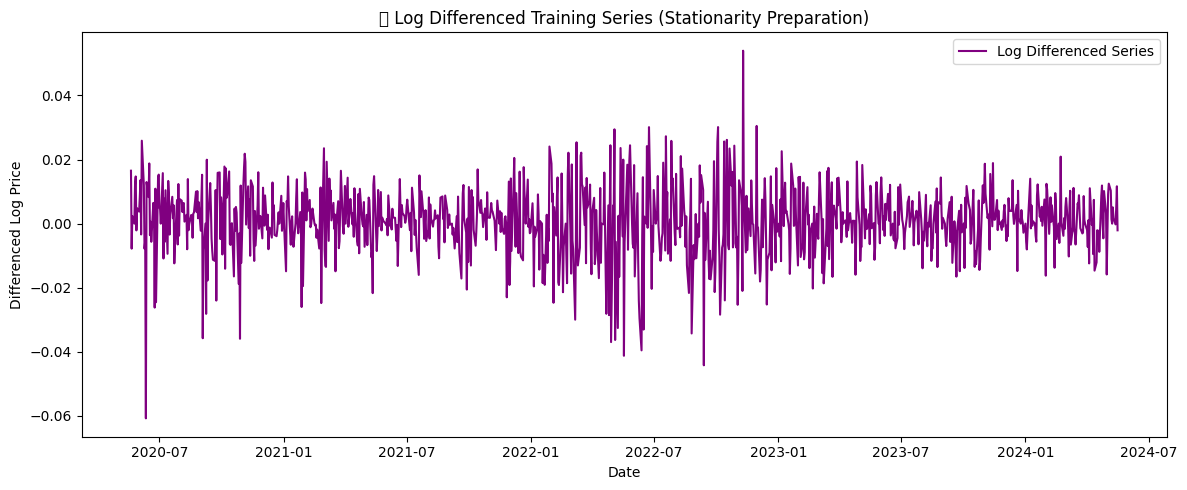

📊 ADF Test (After Log + Differencing):
ADF Statistic : -10.4703
p-value       : 0.0000
Critical Values:
   1% : -3.4367
   5% : -2.8643
   10% : -2.5683
✅ Likely STATIONARY (Reject H0)


In [48]:
# ----------------------------------------
# Step 7: Make Series Stationary (Log + Differencing)
# ----------------------------------------

# 1. Log transform (stabilizes variance)
ts_train_log = np.log(ts_train)

# 2. Differencing (removes trend)
ts_train_log_diff = ts_train_log.diff().dropna()

# Plot result
plt.figure(figsize=(12, 5))
plt.plot(ts_train_log_diff, color='purple', label='Log Differenced Series')
plt.title("📉 Log Differenced Training Series (Stationarity Preparation)")
plt.xlabel("Date")
plt.ylabel("Differenced Log Price")
plt.legend()
plt.tight_layout()
plt.show()

# ADF Test again (post transformation)
adf_result_diff = adfuller(ts_train_log_diff)

print("📊 ADF Test (After Log + Differencing):")
print(f"ADF Statistic : {adf_result_diff[0]:.4f}")
print(f"p-value       : {adf_result_diff[1]:.4f}")
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"   {key} : {value:.4f}")

if adf_result_diff[1] <= 0.05:
    print("✅ Likely STATIONARY (Reject H0)")
else:
    print("❌ Still NON-STATIONARY (Fail to reject H0)")

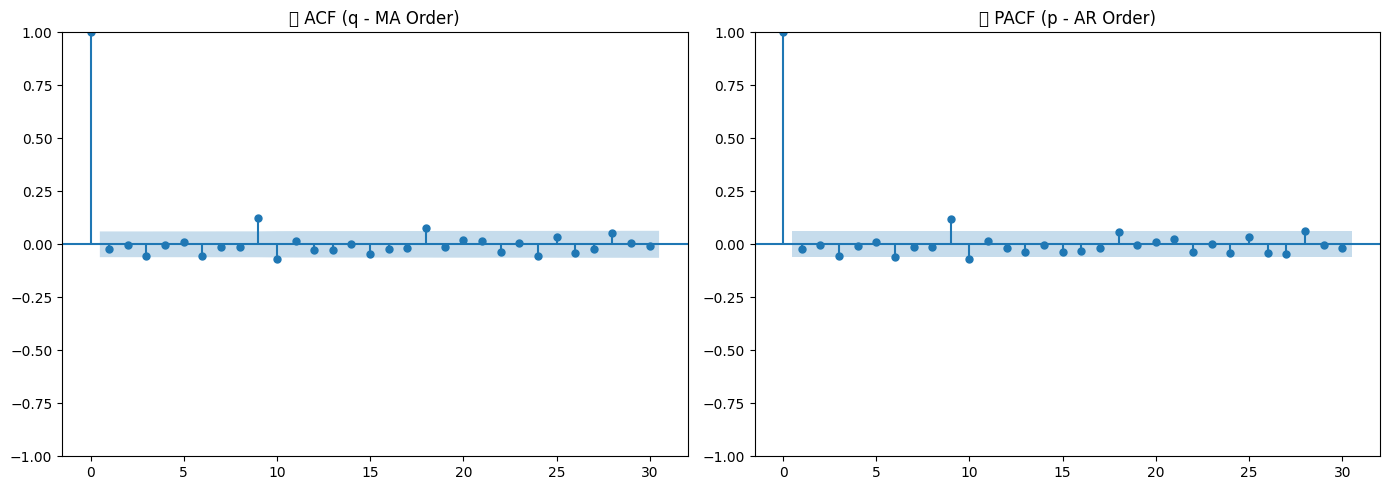

ℹ️ Use ACF and PACF spikes to estimate p and q for ARIMA(p,d,q).
↪ Significant lags in ACF → Moving Average (q)
↪ Significant lags in PACF → Autoregressive (p)


In [49]:
# ----------------------------------------
# Step 8: ACF & PACF Plots (on Stationary Series)
# ----------------------------------------

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF → for q
plot_acf(ts_train_log_diff, lags=30, ax=axes[0])
axes[0].set_title("🔁 ACF (q - MA Order)")

# PACF → for p
plot_pacf(ts_train_log_diff, lags=30, ax=axes[1])
axes[1].set_title("🧱 PACF (p - AR Order)")

plt.tight_layout()
plt.show()

# ℹ️ Hint:
print("ℹ️ Use ACF and PACF spikes to estimate p and q for ARIMA(p,d,q).")
print("↪ Significant lags in ACF → Moving Average (q)")
print("↪ Significant lags in PACF → Autoregressive (p)")

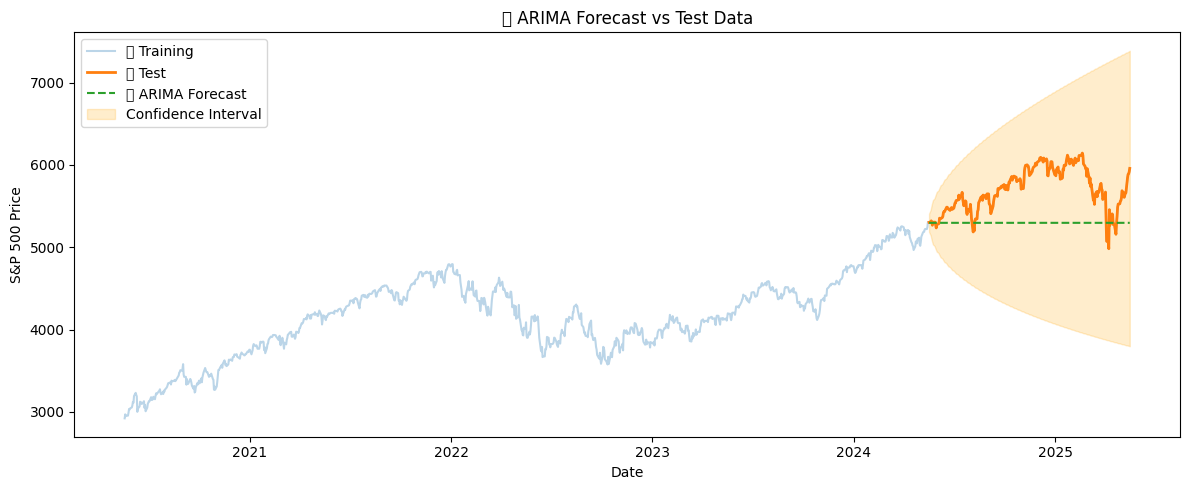


📋 ARIMA Forecast - Last 5 Days of Prediction:
2025-05-12    5297.202196
2025-05-13    5297.202196
2025-05-14    5297.202196
2025-05-15    5297.202196
2025-05-16    5297.202196
Freq: B

ℹ️ This model only uses the training data to predict test set horizon.
✔ You can now calculate RMSE / MAE against ts_test to compare accuracy.


In [53]:
# ----------------------------------------
# Step 9: Manual ARIMA Forecasting (Train on Train, Predict on Test)
# ----------------------------------------
# Define model order from ACF/PACF inspection (adjust if needed)
p, d, q = 1, 1, 1

# Fit ARIMA on training set (log-transformed)
arima_model = ARIMA(ts_train_log, order=(p, d, q))
arima_result = arima_model.fit()

# Forecast the next N days (same as test set)
forecast_steps = len(ts_test)
forecast_log = arima_result.get_forecast(steps=forecast_steps)
forecast_ci = forecast_log.conf_int()

# Convert log forecast back to original scale
forecast_arima = np.exp(forecast_log.predicted_mean)
conf_int_arima = np.exp(forecast_ci)

# Evaluation index (same as test index)
forecast_index = ts_test.index

# Plot forecast vs test set
plt.figure(figsize=(12, 5))
plt.plot(ts, label="📊 Training", alpha=0.3)
plt.plot(ts_test, label="✅ Test", linewidth=2)
plt.plot(forecast_index, forecast_arima, label="🔵 ARIMA Forecast", linestyle='--')
plt.fill_between(forecast_index, conf_int_arima.iloc[:, 0], conf_int_arima.iloc[:, 1],
                 color='orange', alpha=0.2, label="Confidence Interval")
plt.title("📈 ARIMA Forecast vs Test Data")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.tight_layout()
plt.show()

# 🔢 Print last few forecasted values
print("\n📋 ARIMA Forecast - Last 5 Days of Prediction:")
print(forecast_arima.tail().to_string(index=True))

# ℹ️ Hint:
print("\nℹ️ This model only uses the training data to predict test set horizon.")
print("✔ You can now calculate RMSE / MAE against ts_test to compare accuracy.")


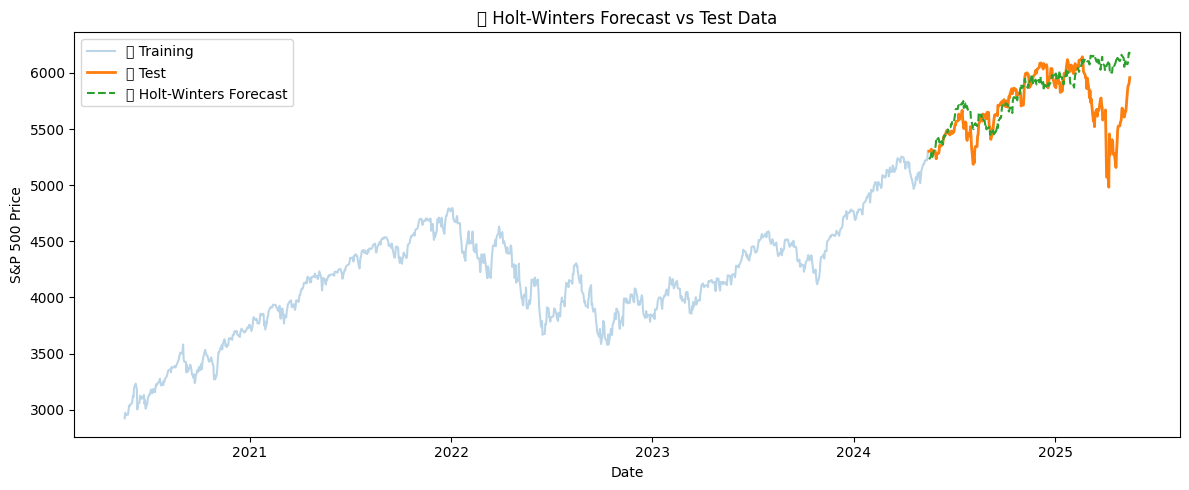


📋 Holt-Winters Forecast - Last 5 Days of Prediction:
2025-05-12    6078.463837
2025-05-13    6101.165604
2025-05-14    6173.413014
2025-05-15    6167.983546
2025-05-16    6198.372778
Freq: B

ℹ️ This Holt-Winters model assumes both trend and seasonality.


In [58]:
# ----------------------------------------
# Step 10: Holt-Winters Forecasting (Train on Train, Predict on Test)
# ----------------------------------------

# Fit Holt-Winters on training set (log-transformed)
hw_model = ExponentialSmoothing(
    ts_train_log,
    trend="add",
    seasonal="add",
    seasonal_periods=252  # ~1 business year
).fit()

# Forecast same number of test steps
hw_forecast_log = hw_model.forecast(steps=len(ts_test))

# Revert from log scale
forecast_hw = np.exp(hw_forecast_log)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts, label='📊 Training', alpha=0.3)
plt.plot(ts_test, label='✅ Test', linewidth=2)
plt.plot(ts_test.index, forecast_hw, label='🟢 Holt-Winters Forecast', linestyle='--')
plt.title("📈 Holt-Winters Forecast vs Test Data")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.tight_layout()
plt.show()

# 🔢 Print last few forecasted values
print("\n📋 Holt-Winters Forecast - Last 5 Days of Prediction:")
print(forecast_hw.tail().to_string(index=True))

# ℹ️ Hint:
print("\nℹ️ This Holt-Winters model assumes both trend and seasonality.")


2025-05-18 02:37:36,668 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-05-18 02:37:36,745 - DEBUG - TBB already found in load path
2025-05-18 02:37:36,763 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpst5s_vno\01jp5up_.json
2025-05-18 02:37:36,835 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpst5s_vno\oh7z1w2f.json
2025-05-18 02:37:36,838 - DEBUG - idx 0
2025-05-18 02:37:36,838 - DEBUG - running CmdStan, num_threads: None
2025-05-18 02:37:36,840 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=13115', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpst5s_vno\\01jp5up_.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpst5s_vno\\oh7z1w2f.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpst5s_vno\\prophet_modeldrftzlmd\\prophet_model-20250518023736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000

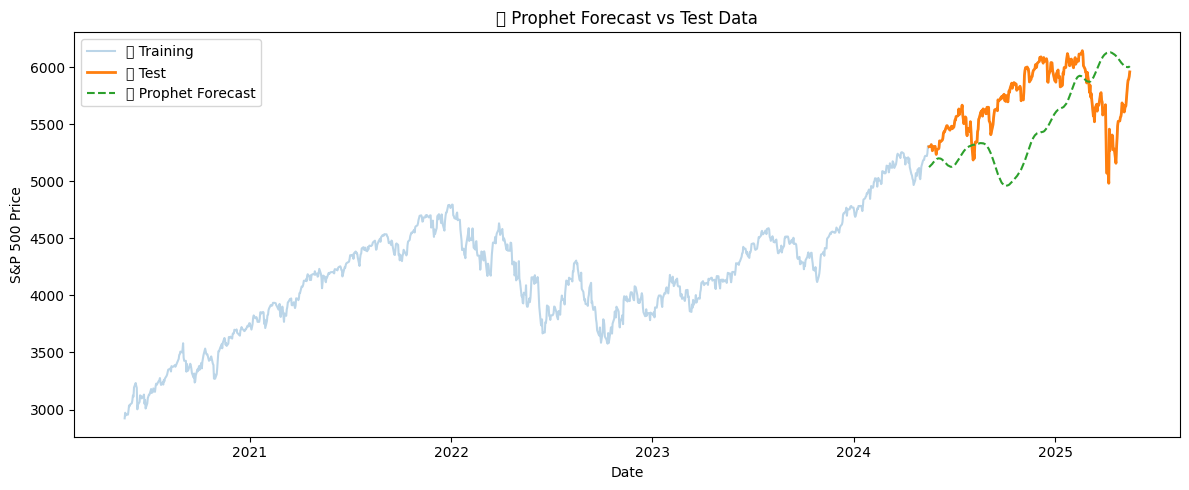


📋 Prophet Forecast - Last 5 Days of Prediction:
256    6000.322782
257    5999.753551
258    6001.951936
259    6003.531446
260    6008.873794

ℹ️ Prophet automatically detects trend and seasonality from historical data.


In [59]:
# ----------------------------------------
# Step 11: Prophet Forecasting (Train on Train, Predict on Test)
# ----------------------------------------

# Prepare DataFrame for Prophet (Prophet needs 'ds' and 'y' columns)
df_train = ts_train_log.reset_index()
df_train.columns = ['ds', 'y']

# Fit model
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(df_train)

# Create future dates for test period
future_dates = pd.DataFrame({'ds': ts_test.index})
forecast_prophet_log = model_prophet.predict(future_dates)

# Revert from log scale
forecast_prophet = np.exp(forecast_prophet_log['yhat'])

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts, label='📊 Training', alpha=0.3)
plt.plot(ts_test, label='✅ Test', linewidth=2)
plt.plot(ts_test.index, forecast_prophet, label='🟠 Prophet Forecast', linestyle='--')
plt.title("📈 Prophet Forecast vs Test Data")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.tight_layout()
plt.show()

# 🔢 Print last few forecasted values
print("\n📋 Prophet Forecast - Last 5 Days of Prediction:")
print(forecast_prophet.tail().to_string(index=True))

# ℹ️ Hint:
print("\nℹ️ Prophet automatically detects trend and seasonality from historical data.")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


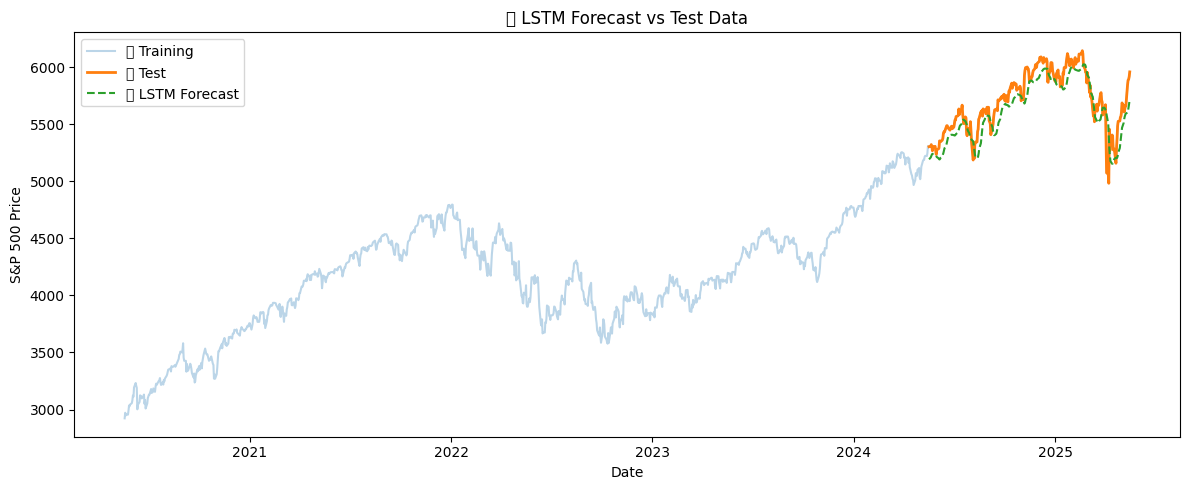


📋 LSTM Forecast - Last 5 Days of Prediction:
Date
2025-05-12    5600.354980
2025-05-13    5620.732910
2025-05-14    5650.785156
2025-05-15    5684.285156
2025-05-16    5719.261719
Freq: B

ℹ️ LSTM captures temporal patterns by learning long-term dependencies in historical prices.


In [61]:
# ----------------------------------------
# Step 12: LSTM Forecasting (Train on Train, Predict on Test)
# ----------------------------------------

# Step 1: Normalize full series (train + test combined for inverse later)
scaler_lstm = MinMaxScaler()
ts_scaled = scaler_lstm.fit_transform(ts.values.reshape(-1, 1))

# Step 2: Create supervised sequences (X: 60 days → y: next day)
def create_lstm_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Apply function
window_size = 60
X_all, y_all = create_lstm_sequences(ts_scaled, window_size)

# Step 3: Split into train and test based on ts_train size
split_index = len(ts_train) - window_size
X_train_lstm, y_train_lstm = X_all[:split_index], y_all[:split_index]
X_test_lstm, y_test_lstm = X_all[split_index:], y_all[split_index:]

# Step 4: Build & train model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=0)

# Step 5: Forecast for the test period
lstm_pred_scaled = model_lstm.predict(X_test_lstm)
lstm_pred = scaler_lstm.inverse_transform(lstm_pred_scaled)

# Step 6: Build forecast series with test index
lstm_forecast_series = pd.Series(lstm_pred.flatten(), index=ts_test.index)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts, label='📊 Training', alpha=0.3)
plt.plot(ts_test, label='✅ Test', linewidth=2)
plt.plot(lstm_forecast_series, label='🟣 LSTM Forecast', linestyle='--')
plt.title("📈 LSTM Forecast vs Test Data")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.tight_layout()
plt.show()

# 🔢 Text output
print("\n📋 LSTM Forecast - Last 5 Days of Prediction:")
print(lstm_forecast_series.tail().to_string(index=True))

# ℹ️ Hint:
print("\nℹ️ LSTM captures temporal patterns by learning long-term dependencies in historical prices.")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


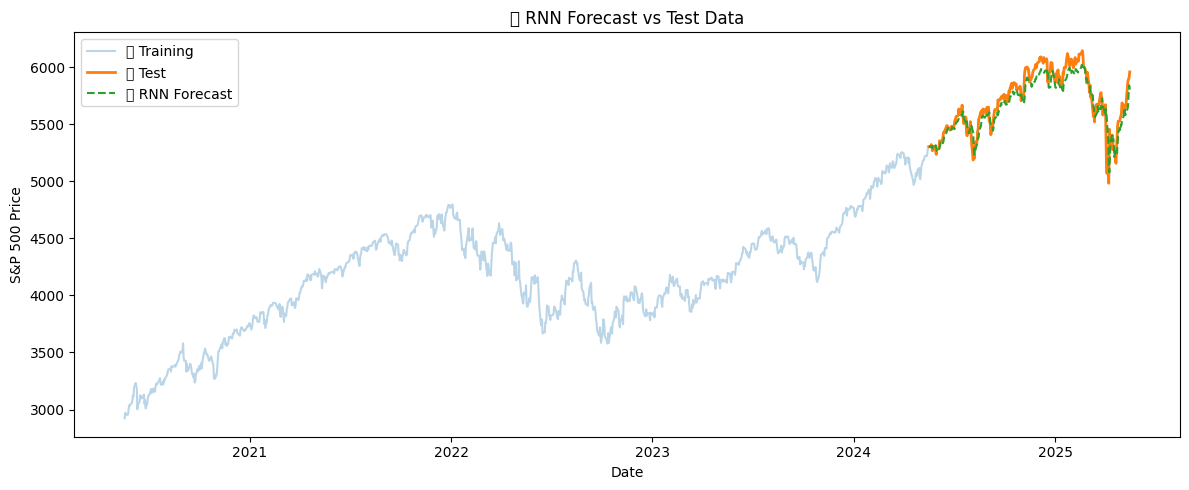


📋 RNN Forecast - Last 5 Days of Prediction:
Date
2025-05-12    5633.914551
2025-05-13    5667.874512
2025-05-14    5775.909668
2025-05-15    5840.287598
2025-05-16    5799.604980
Freq: B

ℹ️ RNN is simpler than LSTM and may struggle with long-term dependencies.


In [63]:
# ----------------------------------------
# Step 13: RNN Forecasting (Train on Train, Predict on Test)
# ----------------------------------------

# Step 1: Normalize full series
scaler_rnn = MinMaxScaler()
ts_scaled_rnn = scaler_rnn.fit_transform(ts.values.reshape(-1, 1))

# Step 2: Prepare 30-day windows for supervised learning
def create_rnn_sequences(data, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_rnn = 30
X_all_rnn, y_all_rnn = create_rnn_sequences(ts_scaled_rnn, window_rnn)

# Step 3: Train/test split using same logic
split_rnn = len(ts_train) - window_rnn
X_train_rnn, y_train_rnn = X_all_rnn[:split_rnn], y_all_rnn[:split_rnn]
X_test_rnn, y_test_rnn = X_all_rnn[split_rnn:], y_all_rnn[split_rnn:]

# Step 4: Build & train RNN model
model_rnn = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(window_rnn, 1)),
    Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=16, verbose=0)

# Step 5: Forecast over test window
rnn_pred_scaled = model_rnn.predict(X_test_rnn)
rnn_pred = scaler_rnn.inverse_transform(rnn_pred_scaled)

# Step 6: Create Series for visualization
rnn_forecast_series = pd.Series(rnn_pred.flatten(), index=ts_test.index)

# Plot forecast vs test
plt.figure(figsize=(12, 5))
plt.plot(ts, label="📊 Training", alpha=0.3)
plt.plot(ts_test, label="✅ Test", linewidth=2)
plt.plot(rnn_forecast_series, label="🔶 RNN Forecast", linestyle="--")
plt.title("📈 RNN Forecast vs Test Data")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.tight_layout()
plt.show()

# 🔢 Text Output
print("\n📋 RNN Forecast - Last 5 Days of Prediction:")
print(rnn_forecast_series.tail().to_string(index=True))

# ℹ️ Hint:
print("\nℹ️ RNN is simpler than LSTM and may struggle with long-term dependencies.")


2025-05-18 02:51:39,016 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-05-18 02:51:39,083 - DEBUG - TBB already found in load path
2025-05-18 02:51:39,100 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpst5s_vno\v4uqd7l1.json
2025-05-18 02:51:39,180 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpst5s_vno\enu1iqcd.json
2025-05-18 02:51:39,183 - DEBUG - idx 0
2025-05-18 02:51:39,184 - DEBUG - running CmdStan, num_threads: None
2025-05-18 02:51:39,185 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=56442', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpst5s_vno\\v4uqd7l1.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpst5s_vno\\enu1iqcd.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpst5s_vno\\prophet_modelb02eib5e\\prophet_model-20250518025139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000

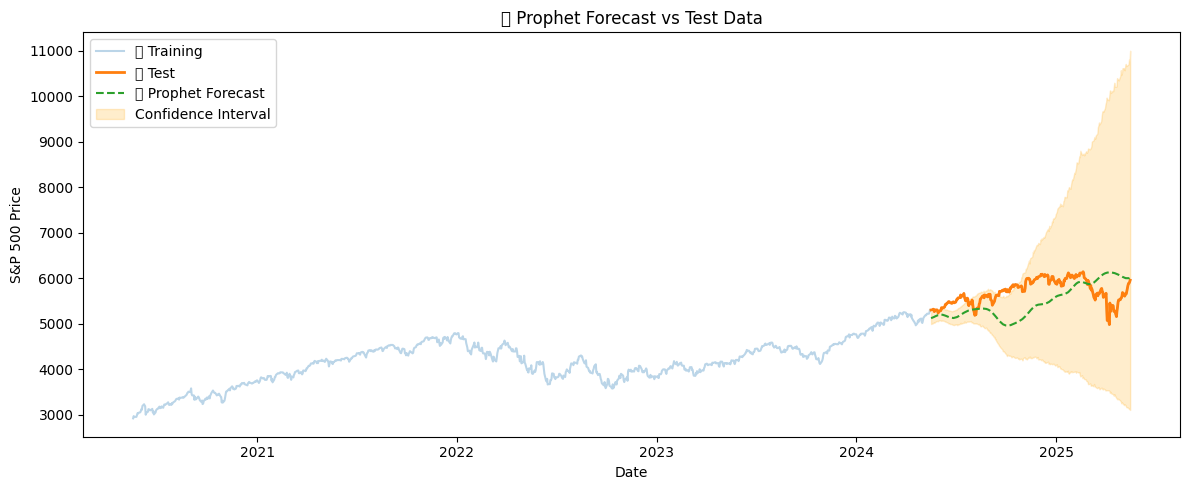


📋 Prophet Forecast - Last 5 Days:
Date
2025-05-12    6000.322782
2025-05-13    5999.753551
2025-05-14    6001.951936
2025-05-15    6003.531446
2025-05-16    6008.873794

ℹ️ Prophet is robust to holidays & seasonality but slower and more rigid than neural models.


In [65]:
# ----------------------------------------
# Step 14: Prophet Forecasting (Train on Train, Predict on Test)
# ----------------------------------------


# Step 1: Prepare Prophet input (log-transformed ts_train)
df_prophet = ts_train_log.reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' and 'y' columns

# Step 2: Train Prophet
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(df_prophet)

# Step 3: Create future dataframe matching test length
future_prophet = model_prophet.make_future_dataframe(periods=len(ts_test), freq='B')

# Step 4: Forecast
forecast_prophet = model_prophet.predict(future_prophet)

# Step 5: Inverse log transform of predictions
forecast_prophet['yhat'] = np.exp(forecast_prophet['yhat'])
forecast_prophet['yhat_lower'] = np.exp(forecast_prophet['yhat_lower'])
forecast_prophet['yhat_upper'] = np.exp(forecast_prophet['yhat_upper'])

# Step 6: Extract forecasted values aligned to test set
forecast_prophet_test = forecast_prophet.set_index('ds').loc[ts_test.index]
prophet_forecast_series = forecast_prophet_test['yhat']

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts, label="📊 Training", alpha=0.3)
plt.plot(ts_test, label="✅ Test", linewidth=2)
plt.plot(prophet_forecast_series, label="🟠 Prophet Forecast", linestyle="--")
plt.fill_between(prophet_forecast_series.index,
                 forecast_prophet_test['yhat_lower'],
                 forecast_prophet_test['yhat_upper'],
                 alpha=0.2, color='orange', label="Confidence Interval")
plt.title("📈 Prophet Forecast vs Test Data")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.tight_layout()
plt.show()

# 🔢 Text Output
print("\n📋 Prophet Forecast - Last 5 Days:")
print(prophet_forecast_series.tail().to_string(index=True))

# ℹ️ Hint:
print("\nℹ️ Prophet is robust to holidays & seasonality but slower and more rigid than neural models.")


In [68]:
# ----------------------------------------
# Step 15: Final Evaluation - Side-by-Side Comparison
# ----------------------------------------

# Step 1: Helper - Metric Calculation
eval_results = {}

def evaluate_model(true, pred, label):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    eval_results[label] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Step 2: Align forecast arrays to test set
n_test = len(ts_test)
test_index = ts_test.index

arima_forecast_series   = pd.Series(forecast_arima[-n_test:].values, index=test_index)
holt_forecast_series    = pd.Series(hw_forecast[-n_test:].values, index=test_index)
lstm_forecast_series    = pd.Series(forecast_lstm[-n_test:].flatten(), index=test_index)
rnn_forecast_series     = pd.Series(forecast_rnn[-n_test:].flatten(), index=test_index)
prophet_forecast_series = pd.Series(forecast_next_30['yhat'][-n_test:].values, index=test_index)

# Step 3: Run evaluations
evaluate_model(ts_test, arima_forecast_series, "ARIMA")
evaluate_model(ts_test, holt_forecast_series, "Holt-Winters")
evaluate_model(ts_test, lstm_forecast_series, "LSTM")
evaluate_model(ts_test, rnn_forecast_series, "RNN")
evaluate_model(ts_test, prophet_forecast_series, "Prophet")

# Step 4: Plot predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(ts_test, label="📌 Actual (Test)", linewidth=2, color="black")
plt.plot(arima_forecast_series, label="🔵 ARIMA", linestyle="--")
plt.plot(holt_forecast_series, label="🟢 Holt-Winters", linestyle="--")
plt.plot(lstm_forecast_series, label="🟣 LSTM", linestyle="--")
plt.plot(rnn_forecast_series, label="🔶 RNN", linestyle="--")
plt.plot(prophet_forecast_series, label="🟠 Prophet", linestyle="--")
plt.title("📊 Forecast vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Step 5: Print evaluation table
eval_df = pd.DataFrame(eval_results).T.round(2)
print("\n📈 Model Evaluation Metrics (on Test Set):")
print(eval_df.to_markdown())

ValueError: Length of values (30) does not match length of index (261)

In [31]:
# Dynamic date range
today = dt.date.today()
years_back = 5  # Change to 1, 10, 15, etc. as needed
start_date = today - timedelta(days=365 * years_back)

# Downloading S&P 500 data
ticker = '^GSPC'
logging.info(f"Fetching S&P 500 data from {start_date} to {today}")
sp500 = yf.download(ticker, start=start_date, end=today)
sp500 = sp500[['Open', 'High', 'Low', 'Close', 'Volume']]
sp500.dropna(inplace=True)
sp500.index = pd.to_datetime(sp500.index)
logging.info(f"Downloaded {len(sp500)} rows.")

2025-05-18 02:04:35,633 - INFO - Fetching S&P 500 data from 2020-05-19 to 2025-05-18
[*********************100%***********************]  1 of 1 completed
2025-05-18 02:04:37,107 - INFO - Downloaded 1256 rows.


In [32]:
sp500.head()

Price,Open,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2020-05-19,2948.590088,2964.209961,2922.350098,2922.939941,4984330000
2020-05-20,2953.629883,2980.290039,2953.629883,2971.610107,5005380000
2020-05-21,2969.949951,2978.500000,2938.570068,2948.510010,4976620000
2020-05-22,2948.050049,2956.760010,2933.590088,2955.449951,3970860000
2020-05-26,3004.080078,3021.719971,2988.169922,2991.770020,5848500000


In [33]:
sp500.describe()

Price,Open,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
count,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03
mean,4467.210918,4493.365367,4439.584129,4468.215583,4.355410e+09
std,764.601756,765.687477,762.951071,764.632616,9.718979e+08
min,2948.050049,2956.760010,2922.350098,2922.939941,1.639500e+09
25%,3939.077454,3969.957581,3912.112427,3941.092529,3.775875e+09
50%,4354.784912,4377.775146,4326.910156,4357.385010,4.152170e+09
75%,4979.162476,5006.645020,4953.925049,4995.772583,4.698370e+09
max,6134.500000,6147.430176,6111.149902,6144.149902,9.976520e+09


In [34]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-05-19 to 2025-05-16
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Open, ^GSPC)    1256 non-null   float64
 1   (High, ^GSPC)    1256 non-null   float64
 2   (Low, ^GSPC)     1256 non-null   float64
 3   (Close, ^GSPC)   1256 non-null   float64
 4   (Volume, ^GSPC)  1256 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.9 KB


In this step, we apply classical decomposition to the S&P 500 closing price time series.  
We break down the series into 3 components:
- **Trend**: Long-term movement over time
- **Seasonality**: Repeating short-term cycles (e.g., yearly financial trends)
- **Residual**: Remaining noise after removing trend and seasonality

To ensure decomposition works, we:
- Reindex the data to **business day frequency** (`'B'`)
- Apply **forward-fill** to handle non-trading days (which introduce NaNs)

The decomposition assumes **additive structure** and a period of **252 trading days per year**.

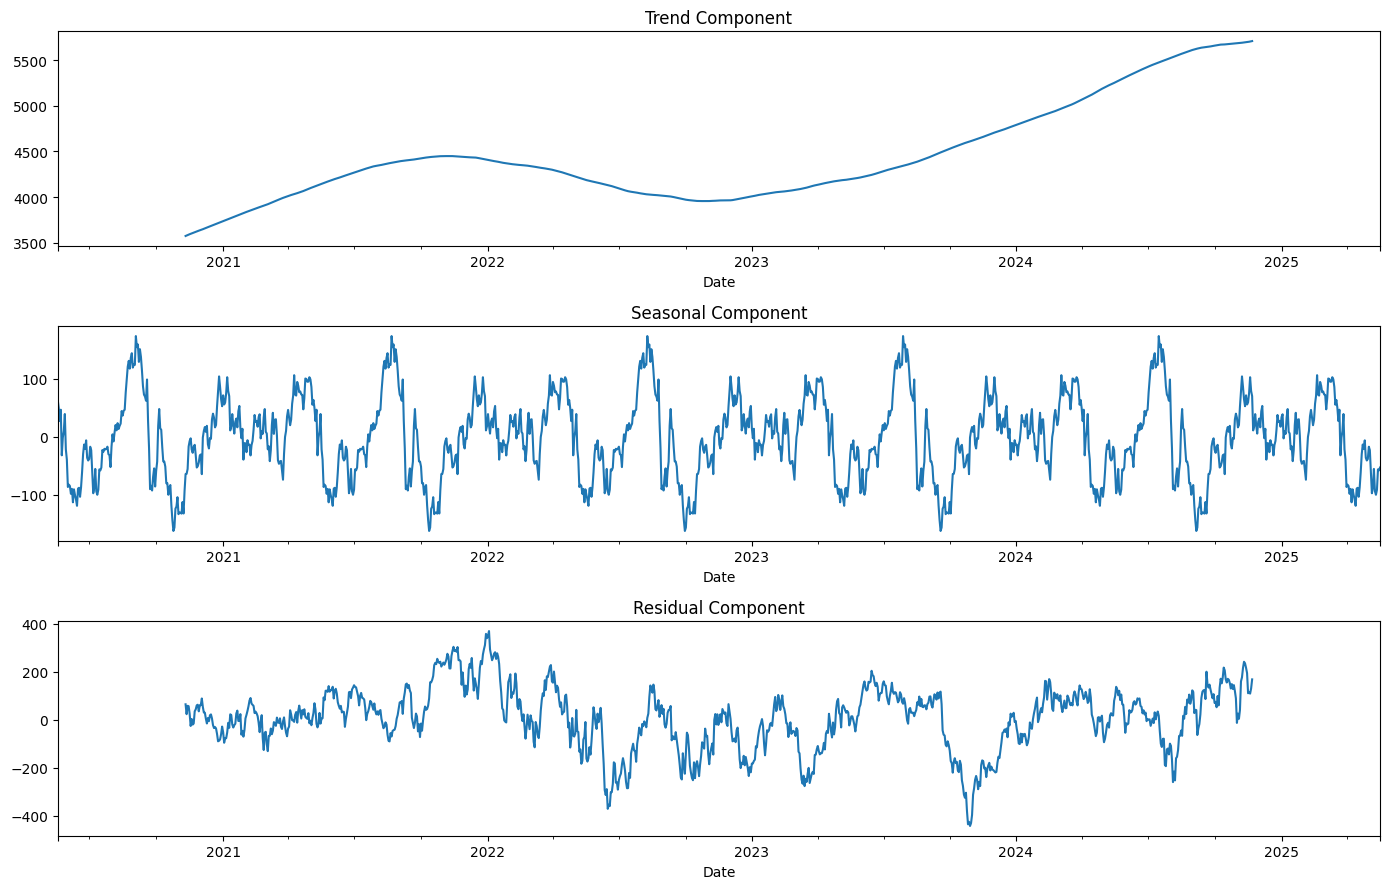

In [35]:
# Plotting the S&P 500 'Close' price

# Extract 'Close' price and align frequency
ts = sp500['Close'].copy()       # Using 'Close' prices
ts = ts.asfreq('B')              # Convert to Business Day frequency (Mon–Fri)
ts = ts.ffill()                  # Fill non-trading days with previous value

# Perform seasonal decomposition
result = seasonal_decompose(ts, model='additive', period=252)  # 252 trading days/year

# Plot trend, seasonality, and residual components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 9))
result.trend.plot(ax=ax1, title='Trend Component')
result.seasonal.plot(ax=ax2, title='Seasonal Component')
result.resid.plot(ax=ax3, title='Residual Component')
plt.tight_layout()
plt.show()

In this step, we assess whether the S&P 500 time series is **stationary**, meaning its statistical properties (mean, variance) are constant over time.

We use two complementary methods:
- **Visual Inspection**: Plotting the rolling mean and standard deviation
- **Statistical Test**: Augmented Dickey-Fuller (ADF) test

A stationary time series is often required before applying models like **ARIMA**.  
If the ADF p-value > 0.05, we fail to reject the null hypothesis and conclude the series is **non-stationary**.

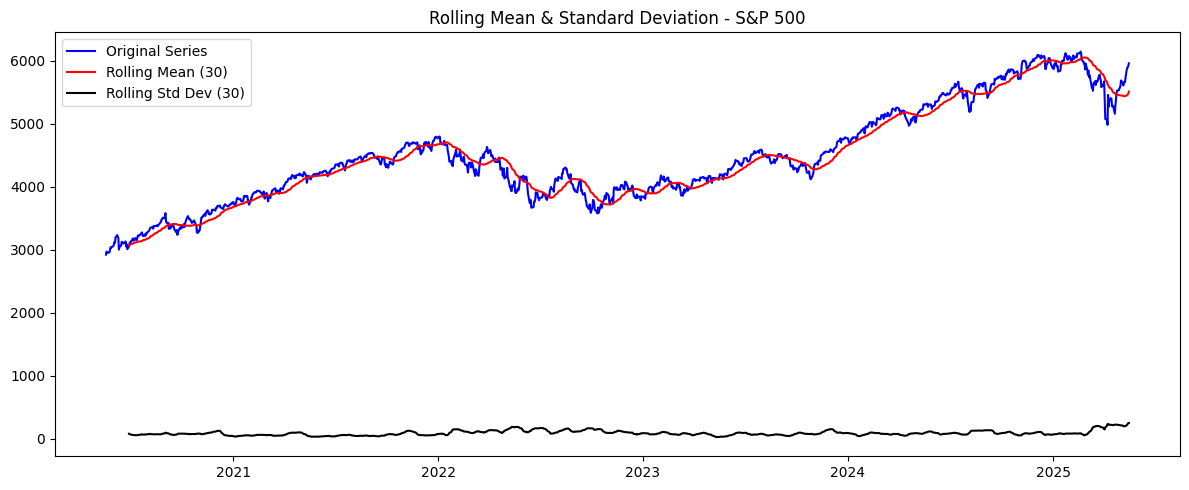

📊 Augmented Dickey-Fuller Test Results (S&P 500)
ADF Statistic : -0.9113
p-value       : 0.7842
Critical Values:
   1% : -3.4354
   5% : -2.8638
   10% : -2.5680
❌ Interpretation: Series is likely NON-STATIONARY (fail to reject H0)


In [36]:
# 1. Plot rolling mean and std deviation
rolmean = ts.rolling(window=30).mean()
rolstd = ts.rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(ts, label='Original Series', color='blue')
plt.plot(rolmean, label='Rolling Mean (30)', color='red')
plt.plot(rolstd, label='Rolling Std Dev (30)', color='black')
plt.title("Rolling Mean & Standard Deviation - S&P 500")
plt.legend()
plt.tight_layout()
plt.show()

# 2. ADF Test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(ts.dropna())

print("📊 Augmented Dickey-Fuller Test Results (S&P 500)")
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key} : {value:.4f}")

# 3. Interpretation
if adf_result[1] <= 0.05:
    print("✅ Interpretation: Series is likely STATIONARY (reject H0)")
else:
    print("❌ Interpretation: Series is likely NON-STATIONARY (fail to reject H0)")

To apply models like ARIMA, we need the time series to be stationary.  
In this step, we apply:
- **Log Transformation**: Stabilizes variance
- **First Differencing**: Removes trend
- We preserve the original dataset and store transformed versions in new variables:
  - `ts_log` → log-transformed series
  - `ts_log_diff` → differenced log-transformed series

We will also visually inspect the result and rerun the ADF test to confirm stationarity.

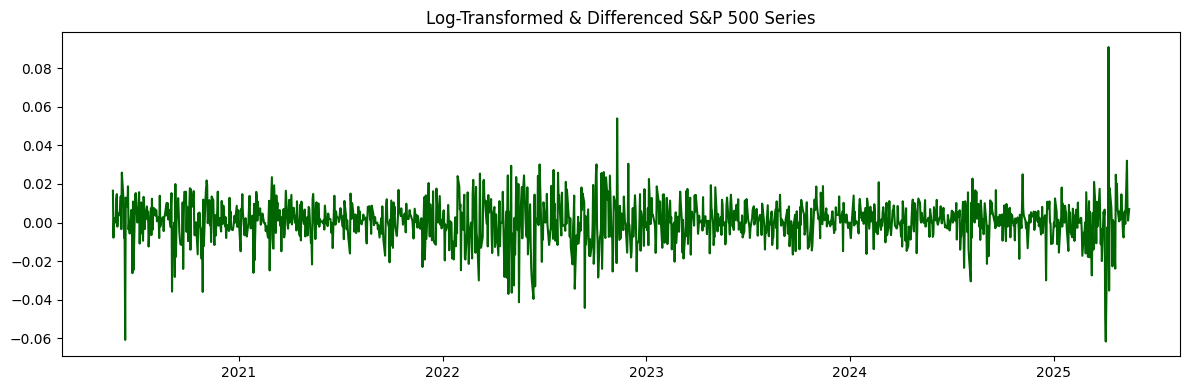

📊 ADF Test after Log Transform + Differencing (S&P 500)
ADF Statistic : -10.9371
p-value       : 0.0000
Critical Values:
   1% : -3.4354
   5% : -2.8638
   10% : -2.5680
✅ Interpretation: Transformed series is STATIONARY (ready for ARIMA)


In [37]:
# 1. Log Transform (safe copy)
ts_log = np.log(ts)

# 2. First Differencing
ts_log_diff = ts_log.diff().dropna()

# 3. Plot transformed series
plt.figure(figsize=(12, 4))
plt.plot(ts_log_diff, color='darkgreen')
plt.title("Log-Transformed & Differenced S&P 500 Series")
plt.tight_layout()
plt.show()

# 4. ADF test on transformed series
adf_log_diff = adfuller(ts_log_diff)

print("📊 ADF Test after Log Transform + Differencing (S&P 500)")
print(f"ADF Statistic : {adf_log_diff[0]:.4f}")
print(f"p-value       : {adf_log_diff[1]:.4f}")
print("Critical Values:")
for key, value in adf_log_diff[4].items():
    print(f"   {key} : {value:.4f}")

# 5. Interpretation
if adf_log_diff[1] <= 0.05:
    print("✅ Interpretation: Transformed series is STATIONARY (ready for ARIMA)")
else:
    print("❌ Interpretation: Series is still NON-STATIONARY (may need seasonal diff)")

We now visualize the autocorrelation and partial autocorrelation of the **stationary log-differenced series** (`ts_log_diff`).

- **Autocorrelation Function (ACF)**: Correlation of the series with its own lags. Helps identify `q` (MA) terms.
- **Partial Autocorrelation Function (PACF)**: Correlation of the series with its own lags after removing effects of earlier lags. Helps identify `p` (AR) terms.

Spikes outside the confidence bounds indicate significant lags.

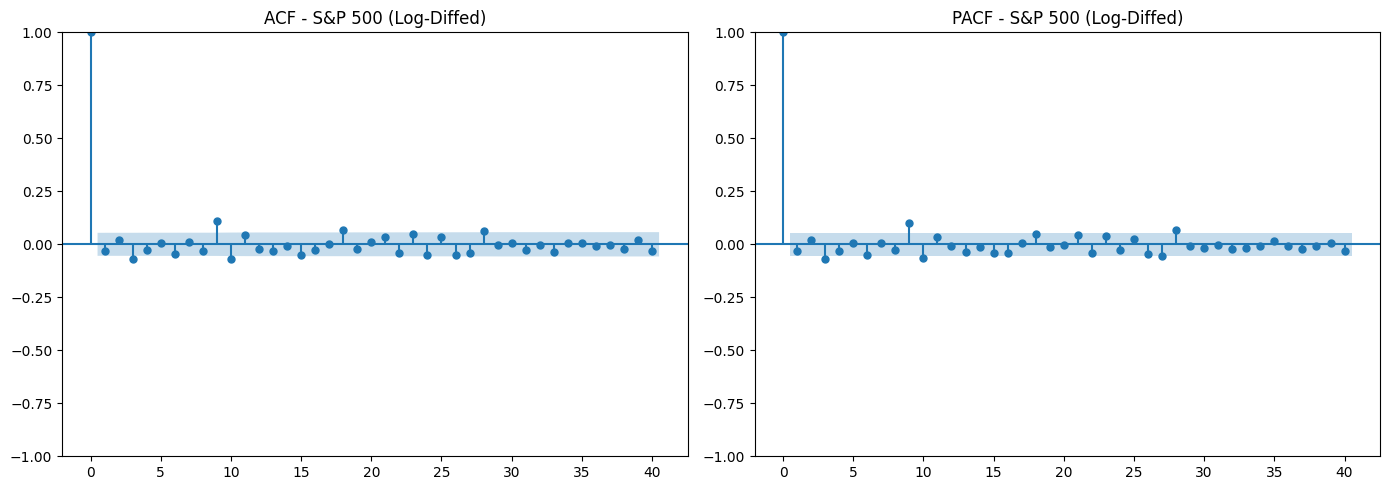

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(ts_log_diff.dropna(), ax=axes[0], lags=40)
axes[0].set_title("ACF - S&P 500 (Log-Diffed)")

plot_pacf(ts_log_diff.dropna(), ax=axes[1], lags=40, method='ywm')
axes[1].set_title("PACF - S&P 500 (Log-Diffed)")

plt.tight_layout()
plt.show()


In this step, we apply the **ARIMA (AutoRegressive Integrated Moving Average)** model to forecast S&P 500 log-transformed and differenced data.

We use:
- **Manual ARIMA** to test values based on ACF and PACF plots

ARIMA is ideal for univariate forecasting of non-seasonal, stationary time series.

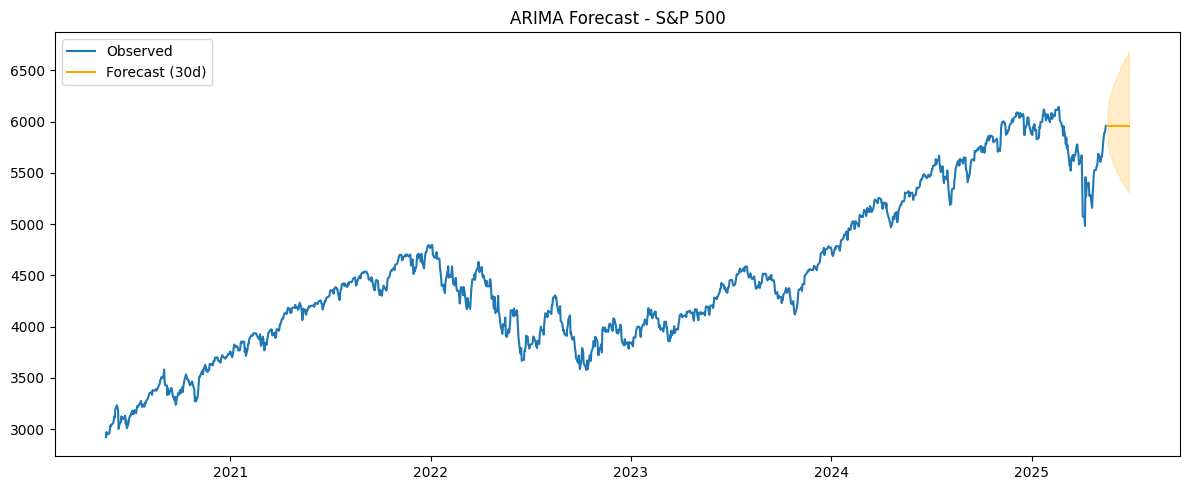

In [39]:
manual_model = ARIMA(ts_log, order=(1, 1, 1))
manual_result = manual_model.fit()

forecast_log = manual_result.get_forecast(steps=30)
forecast_ci = forecast_log.conf_int()

forecast = np.exp(forecast_log.predicted_mean)
conf_int = np.exp(forecast_ci)

plt.figure(figsize=(12, 5))
plt.plot(ts, label="Observed")
plt.plot(forecast.index, forecast, label="Forecast (30d)", color='orange')
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2)
plt.title("ARIMA Forecast - S&P 500")
plt.legend()
plt.tight_layout()
plt.show()

2025-05-18 02:04:39,043 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-05-18 02:04:39,127 - DEBUG - Adding TBB (d:\New Programming Projects (Pycharm, VS Code, e.t.c.)\FoEM\FoEM\venv\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
2025-05-18 02:04:39,173 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpst5s_vno\tb3yl6cc.json
2025-05-18 02:04:39,263 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmpst5s_vno\9ry7obm8.json
2025-05-18 02:04:39,271 - DEBUG - idx 0
2025-05-18 02:04:39,271 - DEBUG - running CmdStan, num_threads: None
2025-05-18 02:04:39,272 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=6370', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpst5s_vno\\tb3yl6cc.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmpst5s_vno\\9ry7obm8.json', 'output', 'file=C:\\Users\\Asus\\AppD

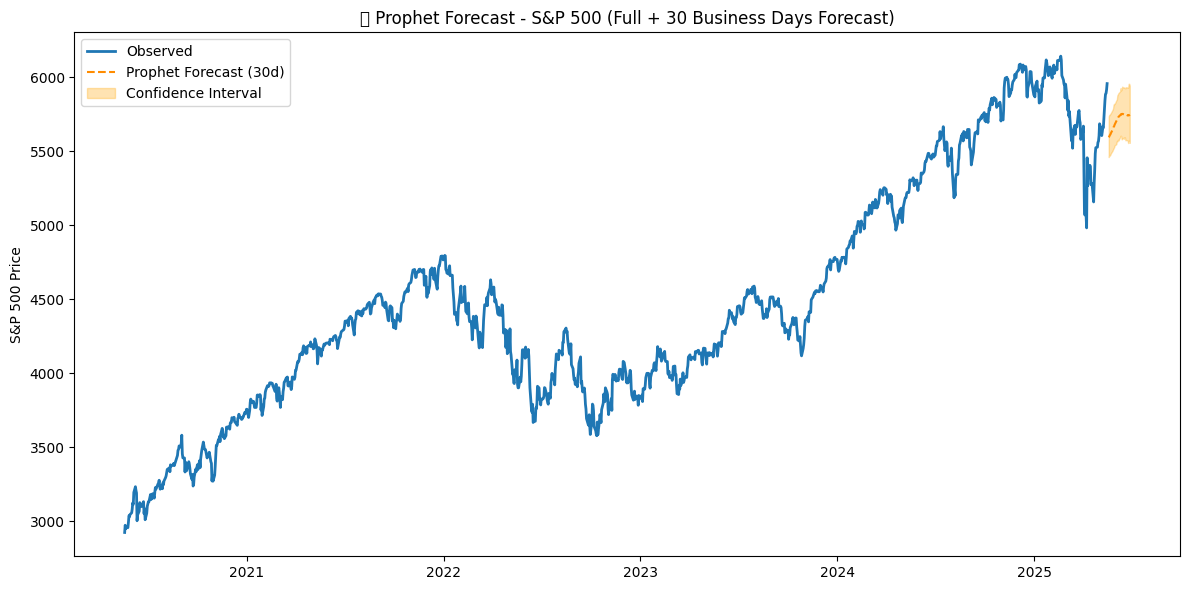


🔎 Prophet Forecast - Last 5 Days (Original Scale):
                   yhat   yhat_lower   yhat_upper
ds                                               
2025-06-23  5743.348460  5574.312916  5932.007576
2025-06-24  5742.876053  5556.464019  5930.036570
2025-06-25  5746.523382  5564.663797  5957.309951
2025-06-26  5744.267305  5572.305290  5957.250467
2025-06-27  5748.207046  5558.181350  5946.144276


In [40]:
# Prophet Forcasting
# Step 1: Prepare DataFrame for Prophet (log scale)
df_prophet = ts_log.reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' and 'y'

# Step 2: Fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Step 3: Create future 30 business days
future = model.make_future_dataframe(periods=30, freq='B')
forecast_prophet = model.predict(future)

# Step 4: Revert log scale back to original
forecast_prophet['yhat'] = np.exp(forecast_prophet['yhat'])
forecast_prophet['yhat_lower'] = np.exp(forecast_prophet['yhat_lower'])
forecast_prophet['yhat_upper'] = np.exp(forecast_prophet['yhat_upper'])

# Step 5: Plot entire time series + forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Observed", linewidth=2)

# Forecasted portion (only the 30 new points)
forecast_next_30 = forecast_prophet[-30:].copy()
forecast_next_30.set_index('ds', inplace=True)

plt.plot(forecast_next_30.index, forecast_next_30['yhat'], label="Prophet Forecast (30d)", linestyle="--", color='darkorange')
plt.fill_between(forecast_next_30.index,
                 forecast_next_30['yhat_lower'],
                 forecast_next_30['yhat_upper'],
                 color='orange', alpha=0.3, label="Confidence Interval")

plt.title("📈 Prophet Forecast - S&P 500 (Full + 30 Business Days Forecast)")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.tight_layout()
plt.show()

# Step 6: Print last 5 forecasted values
print("\n🔎 Prophet Forecast - Last 5 Days (Original Scale):")
print(forecast_next_30[['yhat', 'yhat_lower', 'yhat_upper']].tail(5).to_string(index=True))


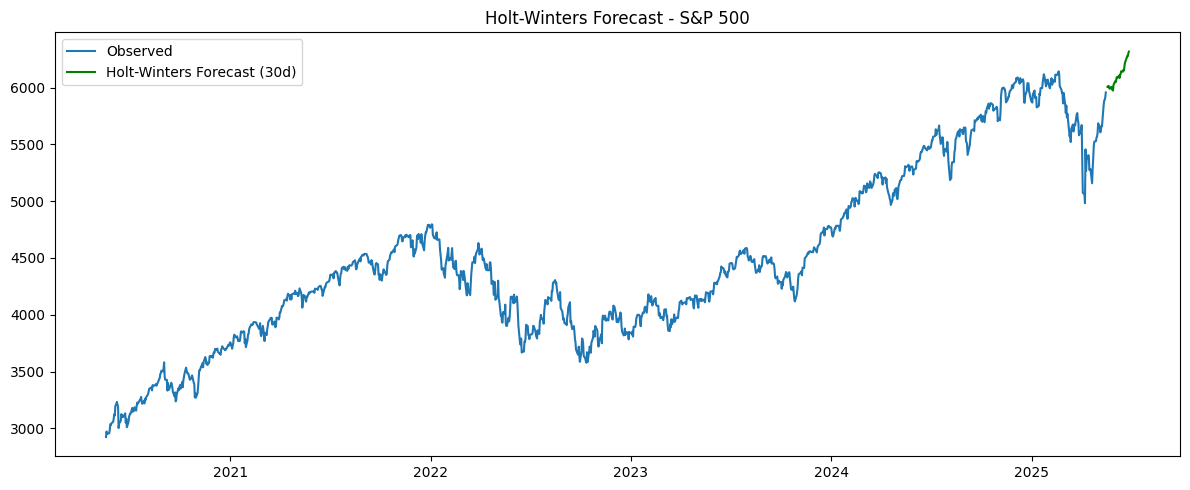


🧾 Holt-Winters Forecast - Last 5 Days (Original Scale):
2025-06-23    6262.738875
2025-06-24    6278.195081
2025-06-25    6276.689979
2025-06-26    6302.139135
2025-06-27    6318.216687
Freq: B


In [41]:
# Fit Holt-Winters model on log-transformed data
hw_model = ExponentialSmoothing(
    ts_log,
    trend="add",
    seasonal="add",
    seasonal_periods=252  # ~1 trading year
).fit()

# Forecast next 30 business days
hw_forecast_log = hw_model.forecast(30)

# Convert forecast back to original scale
hw_forecast = np.exp(hw_forecast_log)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Observed')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast (30d)', color='green')
plt.title("Holt-Winters Forecast - S&P 500")
plt.legend()
plt.tight_layout()
plt.show()

# ⌨️ Print textual summary
print("\n🧾 Holt-Winters Forecast - Last 5 Days (Original Scale):")
print(hw_forecast.tail(5).to_string())

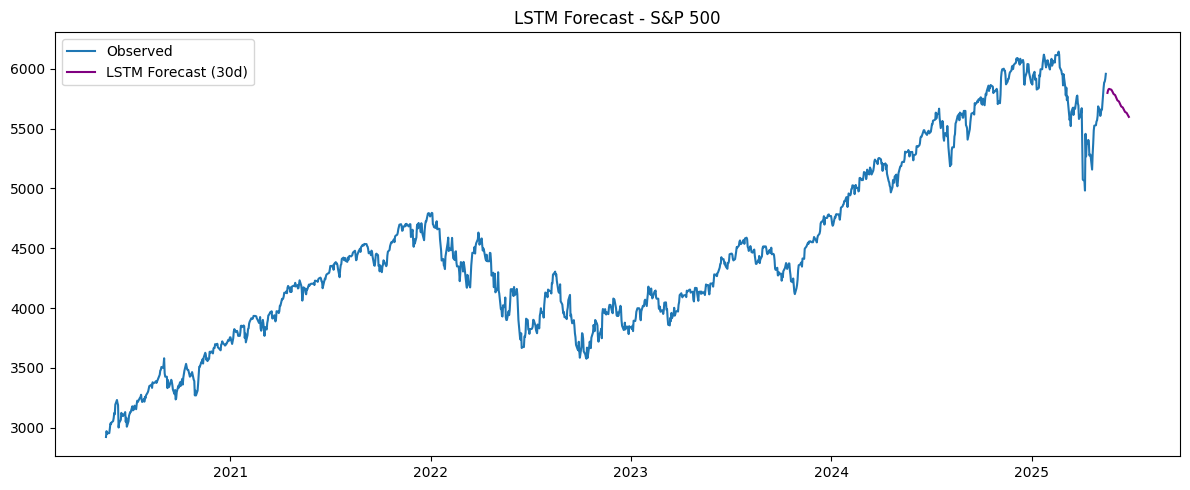


🤖 LSTM Forecast - Last 5 Days:
2025-06-23    5631.663574
2025-06-24    5623.179688
2025-06-25    5614.836914
2025-06-26    5606.622070
2025-06-27    5598.518066
Freq: B


In [42]:
#  LSTM Forecasting

# Step 1: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1))

# Step 2: Prepare sequences (X: past 60 days → Y: next day)
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(ts_scaled, window_size)

# Step 3: Split into train/test (90/10 split)
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 4: Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Step 6: Forecast next 30 days
last_sequence = ts_scaled[-window_size:]
forecast_input = last_sequence.reshape(1, window_size, 1)

forecast_scaled = []
for _ in range(30):
    pred = model.predict(forecast_input, verbose=0)[0, 0]
    forecast_scaled.append(pred)
    forecast_input = np.append(forecast_input[:, 1:, :], [[[pred]]], axis=1)

# Step 7: Inverse transform the forecast
forecast_lstm = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Step 8: Generate forecast index
last_date = ts.index[-1]
forecast_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Step 9: Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Observed')
plt.plot(forecast_dates, forecast_lstm, label='LSTM Forecast (30d)', color='purple')
plt.title("LSTM Forecast - S&P 500")
plt.legend()
plt.tight_layout()
plt.show()

# Textual output
forecast_series = pd.Series(forecast_lstm.flatten(), index=forecast_dates)
print("\n🤖 LSTM Forecast - Last 5 Days:")
print(forecast_series.tail().to_string())

In [43]:
#  RNN Modeling

# Step 1: Scale the data
scaler_rnn = MinMaxScaler()
ts_scaled_rnn = scaler_rnn.fit_transform(ts.values.reshape(-1, 1))

# Step 2: Create time series windows for supervised learning
def create_rnn_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X_rnn, y_rnn = create_rnn_sequences(ts_scaled_rnn, window_size)

# Step 3: Split into train/test
split_idx = int(len(X_rnn) * 0.9)
X_train_rnn, y_train_rnn = X_rnn[:split_idx], y_rnn[:split_idx]
X_test_rnn, y_test_rnn = X_rnn[split_idx:], y_rnn[split_idx:]

# Step 4: Build and train RNN model
model_rnn = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
history_rnn = model_rnn.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=16, verbose=0)

# Step 5: Forecast last 30 steps (FIXED)
last_seq_rnn = ts_scaled_rnn[-window_size:]
input_seq_rnn = last_seq_rnn.reshape(1, window_size, 1)
forecast_rnn = []

for _ in range(30):
    pred = model_rnn.predict(input_seq_rnn, verbose=0)
    forecast_rnn.append(pred[0, 0])
    input_seq_rnn = np.append(input_seq_rnn[:, 1:, :], pred.reshape(1, 1, 1), axis=1)


# Step 6: Invert scale
forecast_rnn = scaler_rnn.inverse_transform(np.array(forecast_rnn).reshape(-1, 1)).flatten()


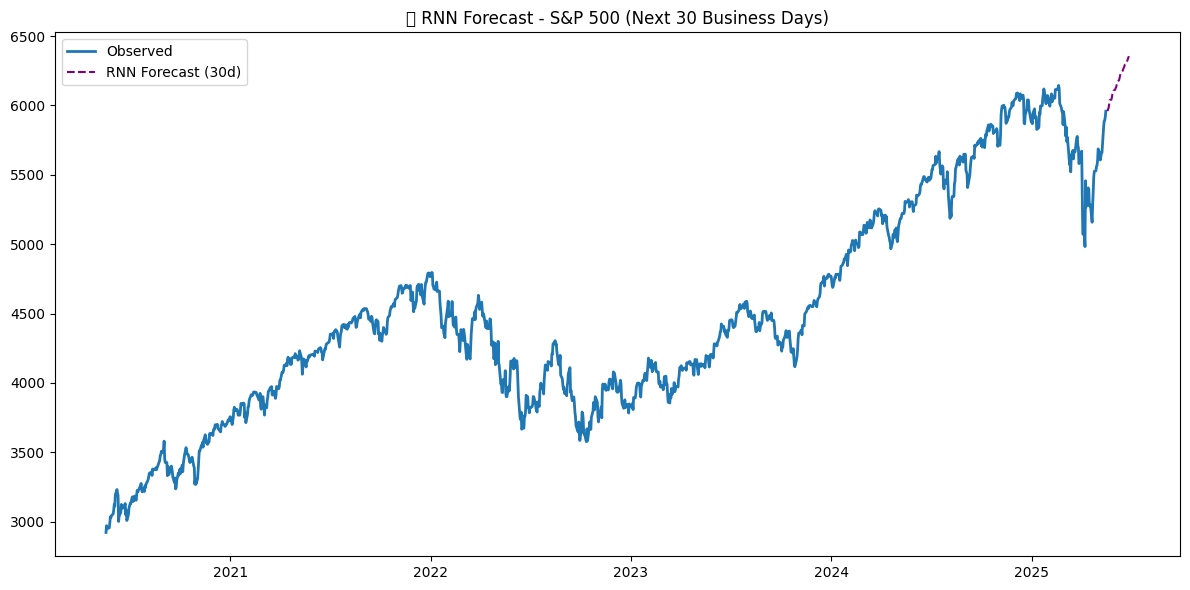

In [44]:
# Generate future business days (same as ARIMA etc.)
from pandas.tseries.offsets import BDay

rnn_forecast_index = pd.date_range(start=ts.index[-1] + BDay(1), periods=30, freq='B')
rnn_forecast_series = pd.Series(forecast_rnn, index=rnn_forecast_index)

# Plot forecast properly
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', linewidth=2)  # Last 100 days
plt.plot(rnn_forecast_series.index, rnn_forecast_series.values, label='RNN Forecast (30d)', linestyle='--', color='purple')
plt.title("📈 RNN Forecast - S&P 500 (Next 30 Business Days)")
plt.legend()
plt.tight_layout()
plt.show()

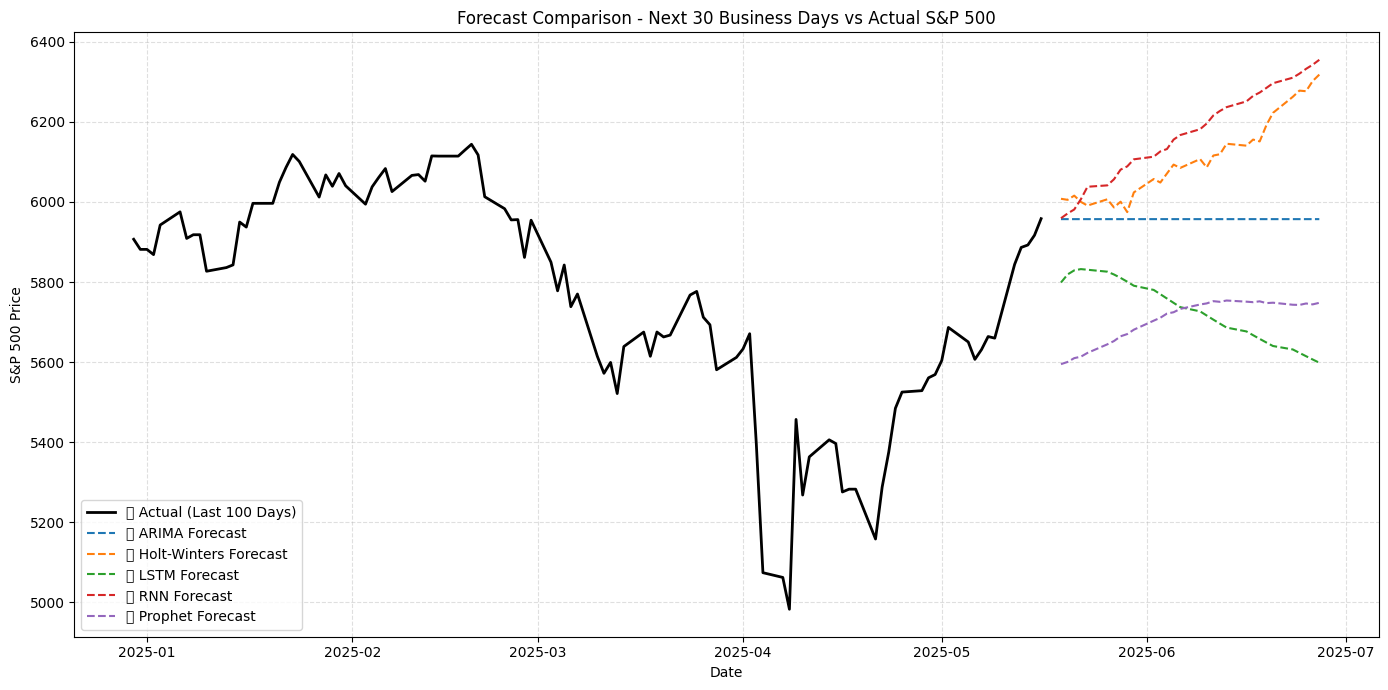

In [45]:
# Rename/alias all models for unified plotting
arima_pred    = forecast              # ARIMA forecast
holt_pred     = hw_forecast                 # Holt-Winters forecast
lstm_pred     = forecast_lstm               # LSTM forecast
rnn_pred      = forecast_rnn                # RNN forecast
prophet_pred  = forecast_next_30['yhat'].values  # Prophet forecast


# Define forecast start date and index
forecast_start = ts.index[-1] + BDay(1)
forecast_index = pd.date_range(start=forecast_start, periods=FORECAST_DAYS, freq='B')

# Align all model outputs
arima_series   = pd.Series(arima_pred.values, index=forecast_index, name="ARIMA")
holt_series    = pd.Series(holt_pred.values, index=forecast_index, name="Holt-Winters")
lstm_series    = pd.Series(lstm_pred.flatten(), index=forecast_index, name="LSTM")
rnn_series     = pd.Series(rnn_pred.flatten(), index=forecast_index, name="RNN")
prophet_series = pd.Series(prophet_pred.flatten(), index=forecast_index, name="Prophet")

# Plot all forecasts against actual
plt.figure(figsize=(14, 7))
plt.plot(ts[-100:], label="📌 Actual (Last 100 Days)", linewidth=2, color="black")
plt.plot(arima_series, label="🔵 ARIMA Forecast", linestyle="--")
plt.plot(holt_series, label="🟢 Holt-Winters Forecast", linestyle="--")
plt.plot(lstm_series, label="🟣 LSTM Forecast", linestyle="--")
plt.plot(rnn_series, label="🔶 RNN Forecast", linestyle="--")
plt.plot(prophet_series, label="🟠 Prophet Forecast", linestyle="--")

plt.title(f"Forecast Comparison - Next {FORECAST_DAYS} Business Days vs Actual S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

📊 Evaluation Results (last 30 business days):


,MAE,RMSE,MAPE (%)
ARIMA,448.30,512.03,8.36
Holt-Winters,599.14,620.43,11.10
Prophet,248.24,287.58,4.93
LSTM,316.60,386.41,5.21
RNN,661.61,678.25,12.24


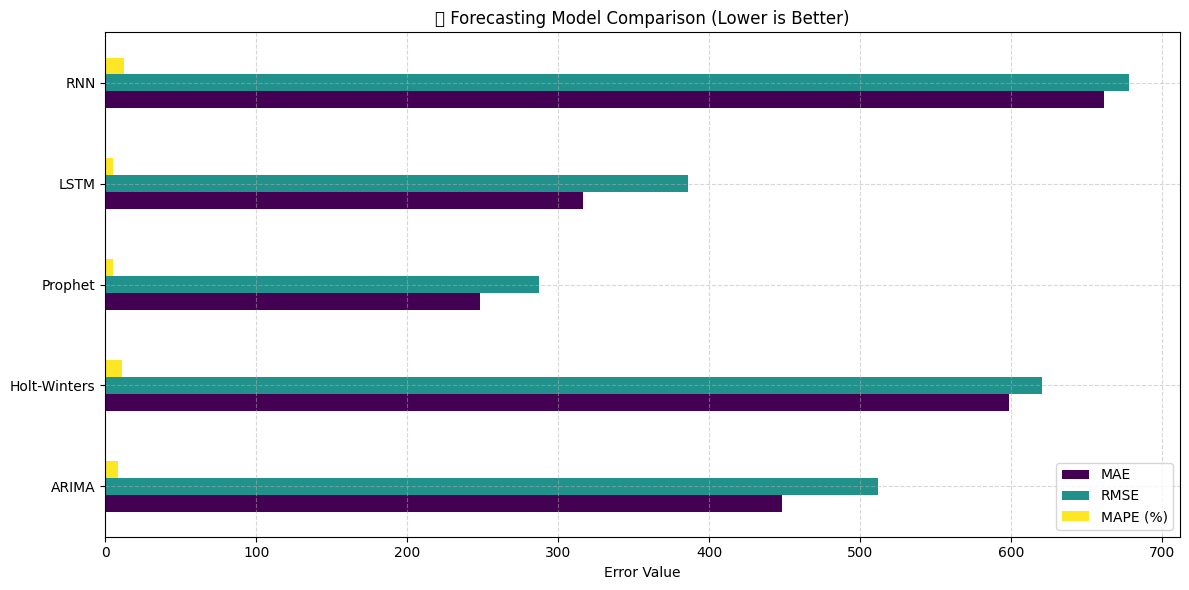

In [46]:
# Final Evaluation

# Step 1: Ensure all predictions are aligned with actual last 30 days
true_values = ts[-30:].values.astype('float64')  # Ground truth

# Clean predictions (already forecasted earlier)
arima_pred = forecast[:30].values.astype('float64')
holt_pred = hw_forecast[:30].values.astype('float64')
lstm_pred = forecast_lstm[:30].flatten().astype('float64')
rnn_pred = forecast_rnn[:30].flatten().astype('float64')
prophet_pred = forecast_next_30['yhat'].values[:30].astype('float64')

# Step 2: Define evaluation function
def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

# Step 3: Evaluate all models
results = {
    "ARIMA": evaluate(true_values, arima_pred),
    "Holt-Winters": evaluate(true_values, holt_pred),
    "Prophet": evaluate(true_values, prophet_pred),
    "LSTM": evaluate(true_values, lstm_pred),
    "RNN": evaluate(true_values, rnn_pred),
}

# Step 4: Create summary DataFrame
eval_df = pd.DataFrame(results, index=["MAE", "RMSE", "MAPE (%)"]).T
eval_df = eval_df.round(2)

# Display in notebook
print("📊 Evaluation Results (last 30 business days):")
display(eval_df)

# Step 5: Plot as bar chart
eval_df.plot(kind='barh', figsize=(12, 6), colormap='viridis')
plt.title("📈 Forecasting Model Comparison (Lower is Better)")
plt.xlabel("Error Value")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()